# Análise de Delivery Center 🛵 🚲 

Nesse projeto vamos explorar os dados de um Delivery center e responder perguntas de negócios.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 100)

# Perguntas de Negócio

- Numa ação de marketing, para atrair mais entregadores, vamos dar uma bonificação para os 20 entregadores que possuem maior distância percorrida ao todo. A bonificação vai variar de acordo com o tipo de profissional que ele é e o modelo que ele usa para se locomover (moto, bike, etc). Levante essas informações.
- Além disso, o time de Pricing precisa ajustar os valores pagos aos entregadores. Para isso, eles precisam da distribuição da distância média percorrida pelos motoqueiros separada por estado, já que cada região terá seu preço.
- Por fim, o CFO precisa de alguns indicadores de receita para apresentar para a diretoria executiva. Dentre esses indicadores, vocês precisarão levantar (1) a receita média e total separada por tipo (Food x Good), (2) A receita média e total por estado. Ou seja, são 4 tabelas ao todo.
- Se a empresa tem um gasto fixo de 5 reais por entrega, recebe 15% do valor de cada entrega como receita e, do total do lucro, distribui 20% em forma de bônus para os 2 mil funcionários, quanto cada um irá receber no período contido no dataset?

In [2]:
# Carregando os dados
drivers = pd.read_csv('/kaggle/input/brazilian-delivery-center/drivers.csv', encoding_errors = 'replace')
channels = pd.read_csv('/kaggle/input/brazilian-delivery-center/channels.csv', encoding_errors = 'replace')
deliveries = pd.read_csv('/kaggle/input/brazilian-delivery-center/deliveries.csv', encoding_errors = 'replace')
hubs = pd.read_csv('/kaggle/input/brazilian-delivery-center/hubs.csv', encoding_errors = 'replace')
orders = pd.read_csv('/kaggle/input/brazilian-delivery-center/orders.csv', encoding_errors = 'replace')
payments = pd.read_csv('/kaggle/input/brazilian-delivery-center/payments.csv', encoding_errors = 'replace')
stores = pd.read_csv('/kaggle/input/brazilian-delivery-center/stores.csv', encoding_errors = 'replace')

# Análise Exploratória dos Dados

In [3]:
drivers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4824 entries, 0 to 4823
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   driver_id     4824 non-null   int64 
 1   driver_modal  4824 non-null   object
 2   driver_type   4824 non-null   object
dtypes: int64(1), object(2)
memory usage: 113.2+ KB


In [4]:
drivers.driver_modal.value_counts(normalize = True)

driver_modal
MOTOBOY    0.66791
BIKER      0.33209
Name: proportion, dtype: float64

De toda a população de entregadores temos 33,2% de ciclistas e 66,8% de motoboys    
Vamos ver quais são os tipos de entrega que temos

In [5]:
deliveries.delivery_status.unique()

array(['DELIVERED', 'CANCELLED', 'DELIVERING'], dtype=object)

In [6]:
deliveries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378843 entries, 0 to 378842
Data columns (total 5 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   delivery_id               378843 non-null  int64  
 1   delivery_order_id         378843 non-null  int64  
 2   driver_id                 362957 non-null  float64
 3   delivery_distance_meters  378770 non-null  float64
 4   delivery_status           378843 non-null  object 
dtypes: float64(2), int64(2), object(1)
memory usage: 14.5+ MB


Temos mais de 10k entregas sem driver_id

In [7]:
deliveries[deliveries.driver_id.isnull()]

,delivery_id,delivery_order_id,driver_id,delivery_distance_meters,delivery_status
7,2174695,68417783,NaN,2564.0,CANCELLED
63,2174845,68424547,NaN,2100.0,CANCELLED
79,2174883,68427057,NaN,2995.0,CANCELLED
149,2175046,68435678,NaN,3958.0,CANCELLED
232,2175267,68441760,NaN,1912.0,DELIVERED
...,...,...,...,...,...
378806,3108863,91142850,NaN,1542.0,DELIVERED
378807,3108867,91131547,NaN,684.0,DELIVERED
378808,3108868,91098770,NaN,2317.0,DELIVERED
378811,3111892,93139184,NaN,1116.0,DELIVERED


Algumas dessas entregas foram canceladas e algumas entregues. Dessas nulas quantas temos para cada status?

In [8]:
deliveries[deliveries.driver_id.isnull()]['delivery_status'].value_counts()

delivery_status
DELIVERED     8601
CANCELLED     7253
DELIVERING      32
Name: count, dtype: int64

Quase metade delas foram canceladas e suponho que a outra metade foi retirada.

Algumas entregas não possuem distancia. Vamos investigar

In [9]:
deliveries[deliveries.delivery_distance_meters.isnull()]

,delivery_id,delivery_order_id,driver_id,delivery_distance_meters,delivery_status
77131,2361710,75039475,33044.0,NaN,DELIVERED
84911,2381351,75643002,598.0,NaN,DELIVERED
86014,2383859,75719915,11522.0,NaN,DELIVERED
86488,2385223,75784315,30449.0,NaN,DELIVERED
92282,2399534,76147079,2354.0,NaN,DELIVERED
...,...,...,...,...,...
369646,3070479,92979697,25651.0,NaN,DELIVERED
375519,3084440,93124741,NaN,NaN,DELIVERED
376259,3086373,93127744,NaN,NaN,DELIVERED
376539,3087113,93128565,NaN,NaN,DELIVERED


As entregas possuem status como entregue e temos o id entregador para algumas. Podemos ter tido algum erro no app na aquisição dessas informações.    
Posteriormente para a bonificação dos entregadores, esses dados não serão contabilizados sem o id do entregador e sem a distância

In [10]:
drv_dlv = drivers.merge(deliveries, on = 'driver_id', how = 'inner')

Vamos olhar apenas entregas concluídas ou em curso

In [11]:
drv_dlv = drv_dlv[(drv_dlv['delivery_status'] == 'DELIVERED')|(drv_dlv['delivery_status'] == 'DELIVERING')]

In [12]:
drv_dlv.describe()

,driver_id,delivery_id,delivery_order_id,delivery_distance_meters
count,362957.000000,3.629570e+05,3.629570e+05,3.629280e+05
mean,21001.777643,2.635875e+06,8.225137e+07,2.818972e+03
std,15520.652243,2.650960e+05,7.009057e+06,1.874356e+04
min,133.000000,2.174658e+06,6.841006e+07,0.000000e+00
25%,7615.000000,2.406183e+06,7.634401e+07,1.172000e+03
50%,18754.000000,2.641931e+06,8.319156e+07,2.044000e+03
75%,31050.000000,2.862952e+06,8.792007e+07,3.419000e+03
max,66459.000000,3.144739e+06,9.313982e+07,7.251291e+06


Como podemos ver acima temos outliers nos dados de distância. Podemos ver isso visualmente através de um boxplot

Text(0.5, 1.0, 'Boxplot de distâncias percorridas')

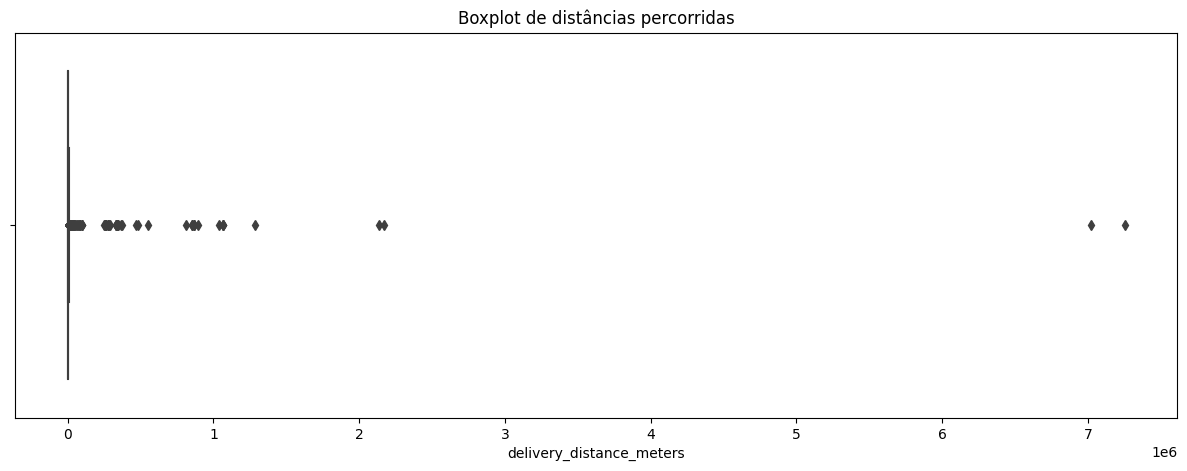

In [13]:
plt.figure(figsize=(15,5))
sns.boxplot(data = drv_dlv, x = 'delivery_distance_meters')
plt.title('Boxplot de distâncias percorridas')

Analisaremos esses outliers superiores utilizando os limites:

Limite inferior = Q1 − 1.5 × IQR    
Limite superior = Q3 + 1.5 × IQR

In [14]:
q3 = drv_dlv.delivery_distance_meters.quantile(0.75)
q1 = drv_dlv.delivery_distance_meters.quantile(0.25)
ls = q3 + 1.5*(q3-q1)

Retirando os outliers nossa distribuição ficaria como mostrado abaixo. No entanto, será que todos esses valores são outliers?

Text(0.07, 1.0, 'removendo outliers')

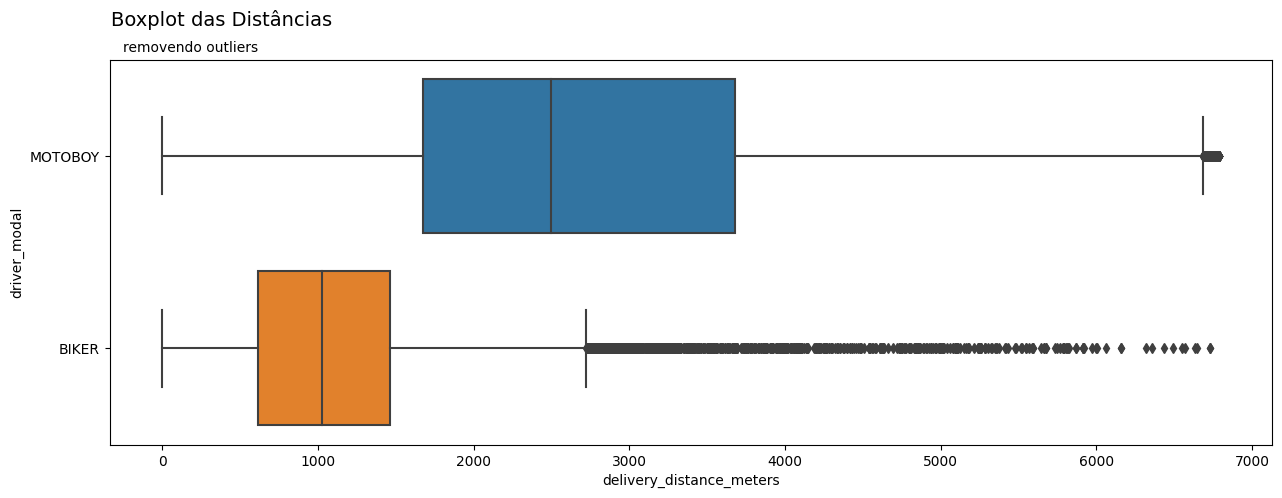

In [15]:
plt.figure(figsize=(15,5))
sns.boxplot(data = drv_dlv[drv_dlv['delivery_distance_meters'] <= ls], x = 'delivery_distance_meters', y = 'driver_modal')
plt.suptitle('Boxplot das Distâncias',x = 0.2, fontsize=14)
plt.title('removendo outliers', fontdict=dict(fontsize=10), x = 0.07)


In [16]:
drv_dlv[drv_dlv['delivery_distance_meters'] > ls].shape

(16296, 7)

Estarei dropando 16296 linhas se descartar todas as distâncias outliers.    
Vamos investigar para qual segmento são essas distâncias, pois distâncias de Goods tendem a ser maiores que distâncias de Food.    
Posteriormente podemos definir algumas premissas para não descartarmos tantos dados.

In [17]:
drv_dlv_str = drv_dlv\
.merge(orders[orders.order_status == 'FINISHED'], left_on = 'delivery_order_id', right_on = 'order_id', copy = False)\
.merge(stores, on = 'store_id', how = 'inner')

drv_dlv_str

,driver_id,driver_modal,driver_type,delivery_id,delivery_order_id_x,delivery_distance_meters,delivery_status,order_id,store_id,channel_id,payment_order_id,delivery_order_id_y,order_status,order_amount,order_delivery_fee,order_delivery_cost,order_created_hour,order_created_minute,order_created_day,order_created_month,order_created_year,order_moment_created,order_moment_accepted,order_moment_ready,order_moment_collected,order_moment_in_expedition,order_moment_delivering,order_moment_delivered,order_moment_finished,order_metric_collected_time,order_metric_paused_time,order_metric_production_time,order_metric_walking_time,order_metric_expediton_speed_time,order_metric_transit_time,order_metric_cycle_time,hub_id,store_name,store_segment,store_plan_price,store_latitude,store_longitude
0,133,MOTOBOY,LOGISTIC OPERATOR,2292758,72836185,2188.0,DELIVERED,72836185,294,5,72836185,72836185,FINISHED,162.90,0.0,8.71,19,28,21,1,2021,1/21/2021 7:28:36 PM,1/21/2021 7:28:51 PM,1/21/2021 7:48:50 PM,1/21/2021 7:48:59 PM,1/21/2021 7:52:47 PM,1/21/2021 7:54:59 PM,NaN,1/21/2021 8:25:23 PM,0.15,2.20,20.22,3.95,6.15,30.38,56.77,13,PAPA SUCIS,FOOD,0.0,-22.885820,-43.279218
1,133,MOTOBOY,LOGISTIC OPERATOR,2292777,72836906,1296.0,DELIVERED,72836906,294,5,72836906,72836906,FINISHED,39.90,0.0,8.88,19,35,21,1,2021,1/21/2021 7:35:36 PM,1/21/2021 7:36:56 PM,1/21/2021 7:49:27 PM,1/21/2021 7:50:11 PM,1/21/2021 7:52:52 PM,1/21/2021 8:01:31 PM,NaN,1/21/2021 8:12:11 PM,0.72,8.65,13.85,3.40,12.07,10.67,36.58,13,PAPA SUCIS,FOOD,0.0,-22.885820,-43.279218
2,133,MOTOBOY,LOGISTIC OPERATOR,2292973,72845357,2402.0,DELIVERED,72845357,1153,5,72845357,72845357,FINISHED,37.80,0.0,9.49,20,40,21,1,2021,1/21/2021 8:40:26 PM,1/21/2021 8:40:34 PM,1/21/2021 8:51:43 PM,1/21/2021 8:55:21 PM,1/21/2021 8:56:11 PM,1/21/2021 9:00:26 PM,NaN,1/21/2021 9:15:46 PM,3.63,4.25,11.28,4.47,8.72,15.35,35.33,13,RIMAI EU TRAPRISCI,FOOD,49.0,-22.887521,-43.283366
3,133,MOTOBOY,LOGISTIC OPERATOR,2301715,73101555,1871.0,DELIVERED,73101555,345,5,73101555,73101555,FINISHED,135.10,9.9,8.71,0,23,23,1,2021,1/23/2021 12:23:42 AM,1/23/2021 12:23:51 AM,1/23/2021 12:46:32 AM,1/23/2021 12:48:58 AM,1/23/2021 12:50:34 AM,1/23/2021 12:51:26 AM,NaN,1/23/2021 1:15:57 AM,2.43,0.87,22.83,4.03,4.88,24.52,52.25,13,ZIM ME MUMEUR,FOOD,49.0,-22.886099,-43.279547
4,133,MOTOBOY,LOGISTIC OPERATOR,2305662,73260366,1309.0,DELIVERED,73260366,294,5,73260366,73260366,FINISHED,37.30,6.9,8.00,21,11,23,1,2021,1/23/2021 9:11:40 PM,1/23/2021 9:12:01 PM,1/23/2021 9:23:06 PM,1/23/2021 9:24:08 PM,1/23/2021 9:26:27 PM,1/23/2021 9:30:19 PM,NaN,1/23/2021 9:39:56 PM,1.03,3.87,11.43,3.35,7.22,9.62,28.25,13,PAPA SUCIS,FOOD,0.0,-22.885820,-43.279218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361160,66457,MOTOBOY,LOGISTIC OPERATOR,3090657,93137262,3075.0,DELIVERED,93137262,659,5,93137262,93137262,FINISHED,148.80,11.9,8.16,22,45,30,4,2021,4/30/2021 10:45:56 PM,4/30/2021 10:46:14 PM,4/30/2021 11:04:16 PM,4/30/2021 11:12:10 PM,4/30/2021 11:16:02 PM,4/30/2021 11:23:34 PM,NaN,4/30/2021 10:45:55 PM,7.90,7.53,18.33,11.75,19.28,NaN,NaN,29,IPUPIEMAI,FOOD,NaN,-23.561053,-46.558976
361161,66457,MOTOBOY,LOGISTIC OPERATOR,3091151,93138273,5997.0,DELIVERED,93138273,659,5,93138273,93138273,FINISHED,105.80,11.9,11.39,23,12,30,4,2021,4/30/2021 11:12:52 PM,4/30/2021 11:13:35 PM,4/30/2021 11:36:18 PM,NaN,4/30/2021 11:43:06 PM,4/30/2021 11:44:16 PM,NaN,5/1/2021 12:31:21 AM,NaN,1.15,23.42,6.82,7.97,47.08,78.48,29,IPUPIEMAI,FOOD,NaN,-23.561053,-46.558976
361162,66457,MOTOBOY,LOGISTIC OPERATOR,3091545,93138497,2807.0,DELIVERED,93138497,3060,5,93138497,93138497,FINISHED,68.43,0.0,8.16,23,21,30,4,2021,4/30/2021 11:21:19 PM,4/30/2021 11:21:55 PM,4/30/2021 11:31:27 PM,4/30/2021 11:55:38 PM,4/30/2021 11:59:07 PM,4/30/2021 11:59:50 PM,NaN,5/1/2021 12:18:16 AM,24.20,0.72,10.13,27.67,28.38,18.43,56.95,29,PIGUE PIPACO,FOOD,49.9,-23.561053,-46.558976
3611

In [18]:
drv_dlv_str[drv_dlv_str['delivery_distance_meters'] > ls].store_segment.value_counts()

store_segment
GOOD    13313
FOOD     2867
Name: count, dtype: int64

Vemos que grande parte dos outliers são de Good mesmo, como previsto, porém precisamos investigar os outliers de Food, se fazem sentido

In [19]:
drv_dlv_str[(drv_dlv_str['delivery_distance_meters'] > ls) & (drv_dlv_str['store_segment'] == 'FOOD')].describe()

,driver_id,delivery_id,delivery_order_id_x,delivery_distance_meters,order_id,store_id,channel_id,payment_order_id,delivery_order_id_y,order_amount,order_delivery_fee,order_delivery_cost,order_created_hour,order_created_minute,order_created_day,order_created_month,order_created_year,order_metric_collected_time,order_metric_paused_time,order_metric_production_time,order_metric_walking_time,order_metric_expediton_speed_time,order_metric_transit_time,order_metric_cycle_time,hub_id,store_plan_price,store_latitude,store_longitude
count,2867.000000,2.867000e+03,2.867000e+03,2.867000e+03,2.867000e+03,2867.000000,2867.000000,2.867000e+03,2.867000e+03,2867.000000,2867.000000,2768.000000,2867.000000,2867.000000,2867.000000,2867.000000,2867.0,2610.000000,2478.000000,2759.000000,2437.000000,2731.000000,2822.000000,2867.000000,2867.000000,2380.000000,2863.000000,2863.000000
mean,21568.977677,2.665743e+06,8.302662e+07,1.450679e+04,8.302662e+07,1500.520405,9.204046,8.302662e+07,8.302662e+07,88.599683,7.095874,12.400527,16.502965,29.802930,16.186955,2.797000,2021.0,2.073077,4.156053,20.633277,3.787050,7.759403,32.584887,66.688054,25.855947,35.061340,-26.964971,-48.791208
std,15435.073043,2.698721e+05,7.049304e+06,1.932096e+05,7.049304e+06,1144.555985,5.891365,7.049304e+06,7.049304e+06,70.919650,5.607993,5.048544,7.172501,17.137652,8.676793,1.079507,0.0,1.921895,8.848732,46.831282,3.627143,10.145644,107.417124,146.986490,17.488901,22.246641,3.126788,2.946259
min,138.000000,2.176595e+06,6.851096e+07,6.790000e+03,6.851096e+07,6.000000,1.000000,6.851096e+07,6.851096e+07,0.010000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2021.0,0.000000,-0.400000,0.020000,0.100000,0.670000,-0.020000,8.100000,3.000000,0.000000,-30.085743,-51.245997
25%,7780.000000,2.434350e+06,7.723879e+07,6.972000e+03,7.723879e+07,659.000000,5.000000,7.723879e+07,7.723879e+07,44.000000,0.000000,11.237500,15.000000,15.000000,9.000000,2.000000,2021.0,0.800000,0.970000,9.335000,1.570000,3.520000,19.170000,39.685000,3.000000,0.010000,-30.038145,-51.203520
50%,22934.000000,2.674559e+06,8.403248e+07,7.298000e+03,8.403248e+07,1057.000000,5.000000,8.403248e+07,8.403248e+07,68.700000,6.900000,12.120000,18.000000,30.000000,17.000000,3.000000,2021.0,1.620000,2.000000,16.030000,3.070000,5.300000,23.770000,49.120000,28.000000,49.000000,-25.477073,-49.316788
75%,31639.000000,2.917302e+06,8.917799e+07,7.970000e+03,8.917799e+07,2026.000000,15.000000,8.917799e+07,8.917799e+07,109.800000,11.900000,13.042500,22.000000,44.000000,24.000000,4.000000,2021.0,2.677500,3.830000,24.075000,4.900000,8.230000,30.845000,61.490000,36.000000,49.900000,-23.563758,-46.652621
max,65157.000000,3.093124e+06,9.313966e+07,7.251291e+06,9.313966e+07,4650.000000,43.000000,9.313966e+07,9.313966e+07,726.620000,79.990000,100.000000,23.000000,59.000000,31.000000,4.000000,2021.0,20.100000,186.930000,1078.320000,42.850000,194.950000,4195.380000,4204.720000,86.000000,49.900000,-22.885820,-43.183534


Observamos outliers bem fora de contexto em FOOD ainda.    
Considerando uma distância máxima de 100km teríamos:

Text(0.11, 1.0, 'outliers por segmento e modalidade')

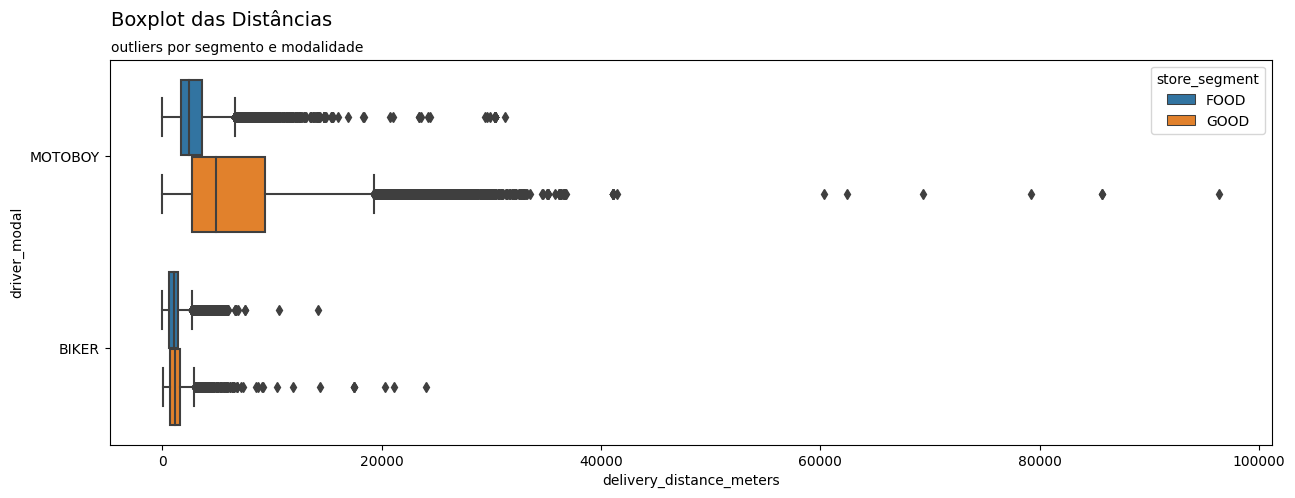

In [20]:
plt.figure(figsize = (15,5))
sns.boxplot(data = drv_dlv_str[(drv_dlv_str['delivery_distance_meters'] < 100000)],
            x = 'delivery_distance_meters', y = 'driver_modal', hue = 'store_segment')
plt.suptitle('Boxplot das Distâncias',x = 0.2, fontsize=14)
plt.title('outliers por segmento e modalidade', fontdict=dict(fontsize=10), x = 0.11)

Para Motoboys considerarei aceitável distâncias até 100 km para Goods e até 40km para Food(considerando entrega em cidade vizinha).    
Ainda observamos distâncias bem fora para ciclistas, vamos analisar.

Text(0.1, 1.0, 'outliers de ciclistas por segmento')

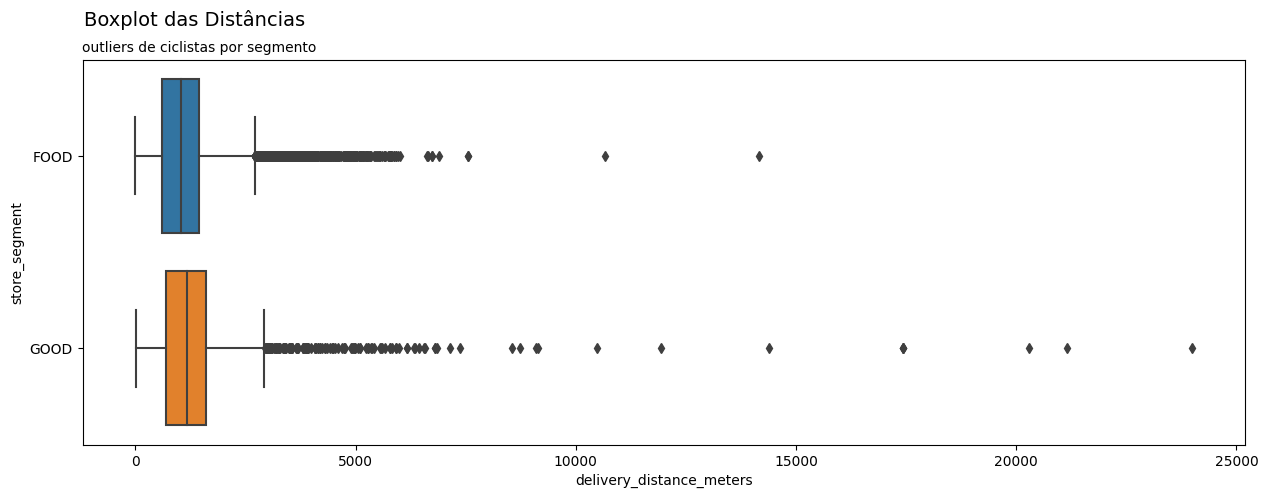

In [21]:
plt.figure(figsize = (15,5))
sns.boxplot(data = drv_dlv_str[(drv_dlv_str['delivery_distance_meters'] < 100000) & (drv_dlv_str['driver_modal'] == 'BIKER')],
            x = 'delivery_distance_meters', y = 'store_segment')
plt.suptitle('Boxplot das Distâncias',x = 0.2, fontsize=14)
plt.title('outliers de ciclistas por segmento', fontdict=dict(fontsize=10), x = 0.10)

Podemos perceber que distâncias acima de 10km percorridas por ciclistas são isoladas. Considerarei que 10km ida e volta para um ciclista é uma distância longa porém cabível. Manteremos outliers abaixo de 10km, para não perdermos dados e prejudicar pessoas que percorreram distâncias maiores de bike.    

Portanto teremos:    
- distâncias para motoboys <= 100km    
- distâncias para ciclistas <= 10km

Portanto teremos a seguinte distribuição:

Text(0.12, 1.0, 'outliers aceitos de ciclistas e motoboys')

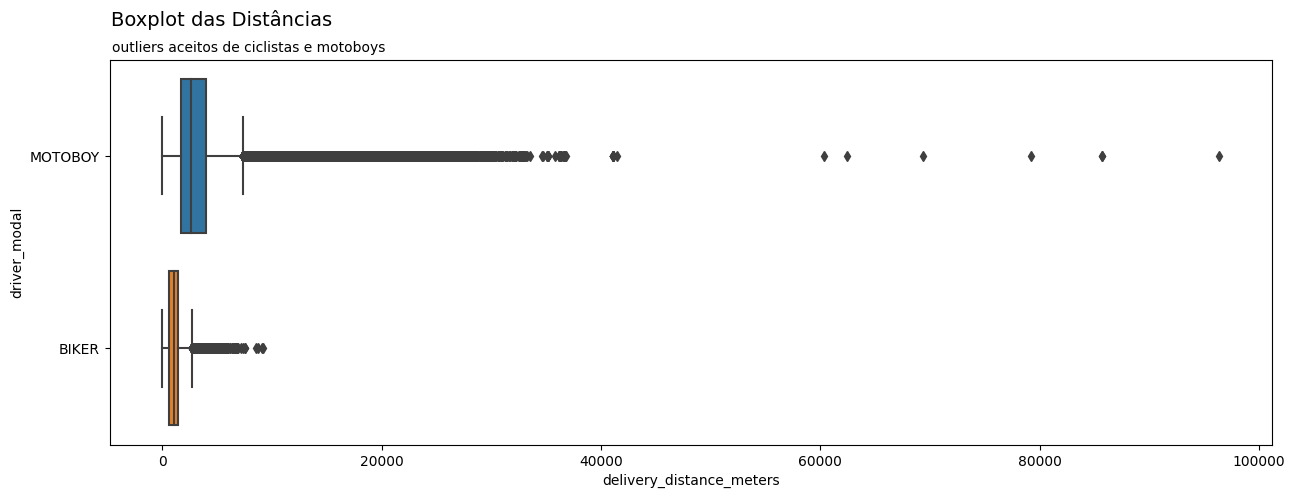

In [22]:
drv_dlv_str_no_outliers = drv_dlv_str[((drv_dlv_str['delivery_distance_meters'] < 100000) & (drv_dlv_str['driver_modal'] == 'MOTOBOY'))|((drv_dlv_str['delivery_distance_meters'] < 10000) & (drv_dlv_str['driver_modal'] == 'BIKER'))]

plt.figure(figsize = (15,5))
sns.boxplot(data = drv_dlv_str_no_outliers, x = 'delivery_distance_meters', y = 'driver_modal')
plt.suptitle('Boxplot das Distâncias',x = 0.2, fontsize=14)
plt.title('outliers aceitos de ciclistas e motoboys', fontdict=dict(fontsize=10), x = 0.12)

# Respostas de Negócio

Com a base saneada vamos responder nossa primeira pergunta de negócio que trata de distências percorridas.    

# Quais os 20 Motoboys e Ciclistas com maior distância total que receberão bonificação?

In [23]:
ranking_motoboys = drv_dlv_str_no_outliers[drv_dlv_str_no_outliers['driver_modal'] == 'MOTOBOY']\
.groupby('driver_id').agg({'delivery_distance_meters':'sum'})\
.nlargest(n = 20, columns = 'delivery_distance_meters')\
.sort_values(by = 'delivery_distance_meters', ascending = False)\
.apply(lambda x:  x / 1000) # passando as distâncias para Km

Text(0.5, 0, 'Total da distância percorrida em km')

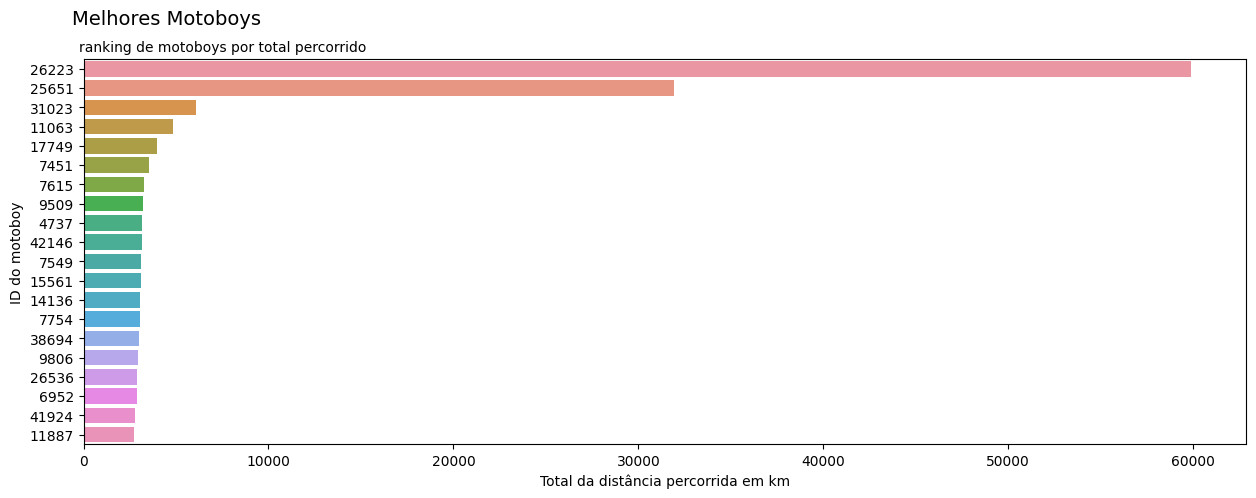

In [24]:
plt.figure(figsize=(15,5))
sns.barplot(data = ranking_motoboys, y = ranking_motoboys.index.astype('str'), x = 'delivery_distance_meters', orient = 'horizontal')
plt.suptitle('Melhores Motoboys',x = 0.18, fontsize=14)
plt.title('ranking de motoboys por total percorrido', fontdict=dict(fontsize=10), x = 0.12)
plt.ylabel('ID do motoboy')
plt.xlabel('Total da distância percorrida em km')

In [25]:
ranking_bikers = drv_dlv_str_no_outliers[drv_dlv_str_no_outliers['driver_modal'] == 'BIKER']\
.groupby('driver_id').agg({'delivery_distance_meters':'sum'})\
.nlargest(n = 20, columns = 'delivery_distance_meters')\
.sort_values(by = 'delivery_distance_meters', ascending = False)\
.apply(lambda x:  x / 1000) # passando as distâncias para Km

Text(0.5, 0, 'Total da distância percorrida em km')

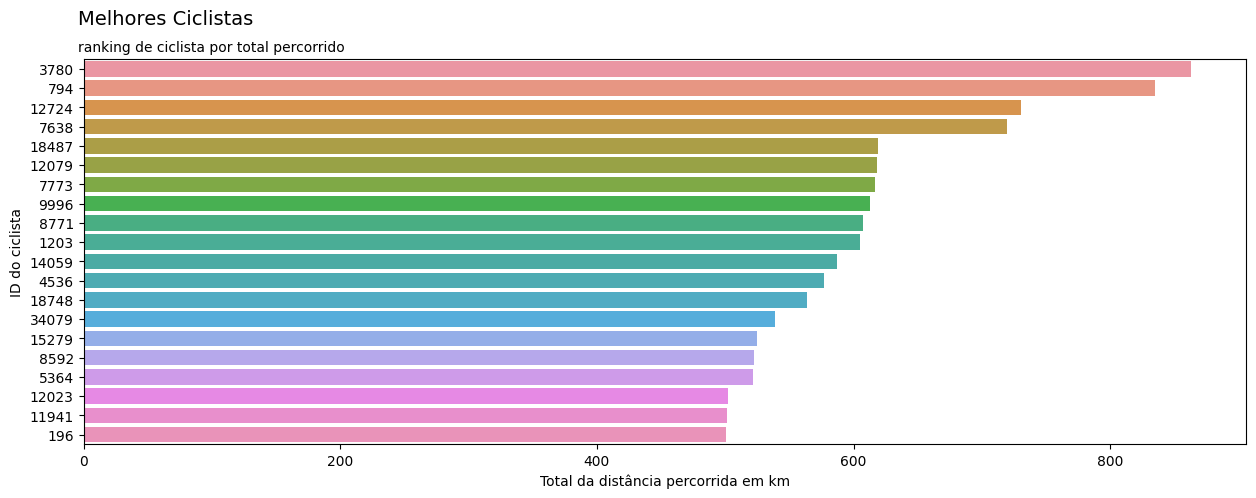

In [26]:
plt.figure(figsize=(15,5))
sns.barplot(data = ranking_bikers, y = ranking_bikers.index.astype('str'), x = 'delivery_distance_meters', orient = 'horizontal')
plt.suptitle('Melhores Ciclistas',x = 0.18, fontsize=14)
plt.title('ranking de ciclista por total percorrido', fontdict=dict(fontsize=10), x = 0.11)
plt.ylabel('ID do ciclista')
plt.xlabel('Total da distância percorrida em km')

# Como é a distribuição das entregas por segmento e por estado?

Primeiramente vamos unir as tabelas necessárias

In [27]:
drv_dlv_str_hub = drv_dlv_str_no_outliers.merge(hubs, on = 'hub_id', how = 'inner')
drv_dlv_str_hub

,driver_id,driver_modal,driver_type,delivery_id,delivery_order_id_x,delivery_distance_meters,delivery_status,order_id,store_id,channel_id,payment_order_id,delivery_order_id_y,order_status,order_amount,order_delivery_fee,order_delivery_cost,order_created_hour,order_created_minute,order_created_day,order_created_month,order_created_year,order_moment_created,order_moment_accepted,order_moment_ready,order_moment_collected,order_moment_in_expedition,order_moment_delivering,order_moment_delivered,order_moment_finished,order_metric_collected_time,order_metric_paused_time,order_metric_production_time,order_metric_walking_time,order_metric_expediton_speed_time,order_metric_transit_time,order_metric_cycle_time,hub_id,store_name,store_segment,store_plan_price,store_latitude,store_longitude,hub_name,hub_city,hub_state,hub_latitude,hub_longitude
0,133,MOTOBOY,LOGISTIC OPERATOR,2292758,72836185,2188.0,DELIVERED,72836185,294,5,72836185,72836185,FINISHED,162.90,0.0,8.71,19,28,21,1,2021,1/21/2021 7:28:36 PM,1/21/2021 7:28:51 PM,1/21/2021 7:48:50 PM,1/21/2021 7:48:59 PM,1/21/2021 7:52:47 PM,1/21/2021 7:54:59 PM,NaN,1/21/2021 8:25:23 PM,0.15,2.20,20.22,3.95,6.15,30.38,56.77,13,PAPA SUCIS,FOOD,0.0,-22.885820,-43.279218,HIP HOP SHOPPING,RIO DE JANEIRO,RJ,-22.885820,-43.279218
1,133,MOTOBOY,LOGISTIC OPERATOR,2292777,72836906,1296.0,DELIVERED,72836906,294,5,72836906,72836906,FINISHED,39.90,0.0,8.88,19,35,21,1,2021,1/21/2021 7:35:36 PM,1/21/2021 7:36:56 PM,1/21/2021 7:49:27 PM,1/21/2021 7:50:11 PM,1/21/2021 7:52:52 PM,1/21/2021 8:01:31 PM,NaN,1/21/2021 8:12:11 PM,0.72,8.65,13.85,3.40,12.07,10.67,36.58,13,PAPA SUCIS,FOOD,0.0,-22.885820,-43.279218,HIP HOP SHOPPING,RIO DE JANEIRO,RJ,-22.885820,-43.279218
2,133,MOTOBOY,LOGISTIC OPERATOR,2292973,72845357,2402.0,DELIVERED,72845357,1153,5,72845357,72845357,FINISHED,37.80,0.0,9.49,20,40,21,1,2021,1/21/2021 8:40:26 PM,1/21/2021 8:40:34 PM,1/21/2021 8:51:43 PM,1/21/2021 8:55:21 PM,1/21/2021 8:56:11 PM,1/21/2021 9:00:26 PM,NaN,1/21/2021 9:15:46 PM,3.63,4.25,11.28,4.47,8.72,15.35,35.33,13,RIMAI EU TRAPRISCI,FOOD,49.0,-22.887521,-43.283366,HIP HOP SHOPPING,RIO DE JANEIRO,RJ,-22.885820,-43.279218
3,133,MOTOBOY,LOGISTIC OPERATOR,2301715,73101555,1871.0,DELIVERED,73101555,345,5,73101555,73101555,FINISHED,135.10,9.9,8.71,0,23,23,1,2021,1/23/2021 12:23:42 AM,1/23/2021 12:23:51 AM,1/23/2021 12:46:32 AM,1/23/2021 12:48:58 AM,1/23/2021 12:50:34 AM,1/23/2021 12:51:26 AM,NaN,1/23/2021 1:15:57 AM,2.43,0.87,22.83,4.03,4.88,24.52,52.25,13,ZIM ME MUMEUR,FOOD,49.0,-22.886099,-43.279547,HIP HOP SHOPPING,RIO DE JANEIRO,RJ,-22.885820,-43.279218
4,133,MOTOBOY,LOGISTIC OPERATOR,2305662,73260366,1309.0,DELIVERED,73260366,294,5,73260366,73260366,FINISHED,37.30,6.9,8.00,21,11,23,1,2021,1/23/2021 9:11:40 PM,1/23/2021 9:12:01 PM,1/23/2021 9:23:06 PM,1/23/2021 9:24:08 PM,1/23/2021 9:26:27 PM,1/23/2021 9:30:19 PM,NaN,1/23/2021 9:39:56 PM,1.03,3.87,11.43,3.35,7.22,9.62,28.25,13,PAPA SUCIS,FOOD,0.0,-22.885820,-43.279218,HIP HOP SHOPPING,RIO DE JANEIRO,RJ,-22.885820,-43.279218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361081,66457,MOTOBOY,LOGISTIC OPERATOR,3090657,93137262,3075.0,DELIVERED,93137262,659,5,93137262,93137262,FINISHED,148.80,11.9,8.16,22,45,30,4,2021,4/30/2021 10:45:56 PM,4/30/2021 10:46:14 PM,4/30/2021 11:04:16 PM,4/30/2021 11:12:10 PM,4/30/2021 11:16:02 PM,4/30/2021 11:23:34 PM,NaN,4/30/2021 10:45:55 PM,7.90,7.53,18.33,11.75,19.28,NaN,NaN,29,IPUPIEMAI,FOOD,NaN,-23.561053,-46.558976,SUBWAY SHOPPING,S�O PAULO,SP,-23.561053,-46.558976
361082,66457,MOTOBOY,LOGISTIC OPERATOR,3091151,93138273,5997.0,DELIVERED,93138273,659,5,93138273,93138273,FINISHED,105.80,11.9,11.39,23,12,30,4,2021,4/30/2021 11:12:52 PM,4/30/2021 11:13:35 PM,4/30/2021 11:36:18 PM,NaN,4/30/2021 11:43:06 PM,4/30/2021 11:44:16 PM,NaN,5/1/2021 12:31:21 AM,NaN,1.15,23.42,6.82,7.97,47.08,78.48,29,IPUPIEMAI,FOOD,NaN,-23.5610

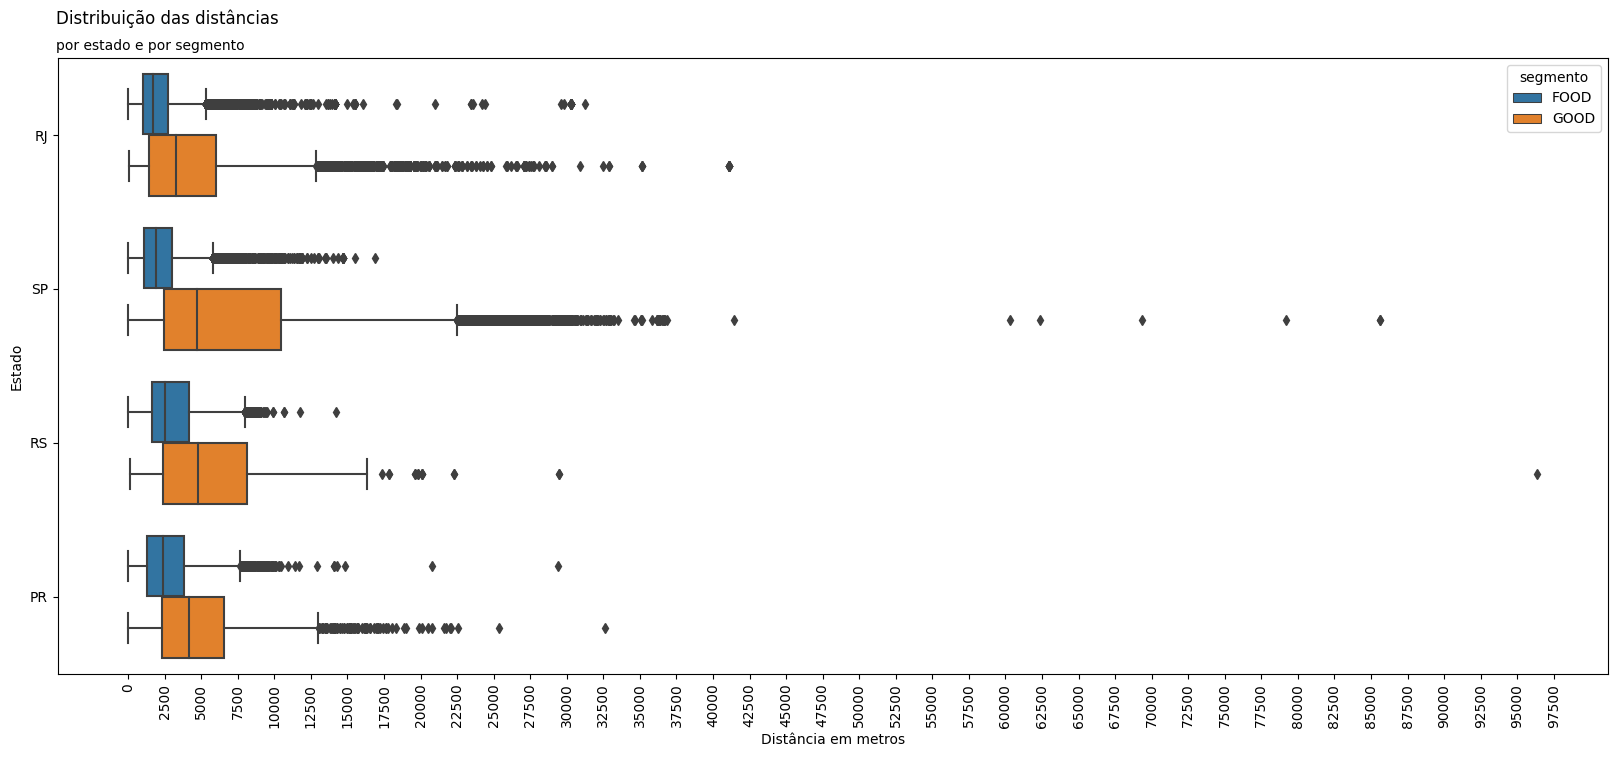

In [28]:
plt.figure(figsize=(20,8))
sns.boxplot(data = drv_dlv_str_hub, x = 'delivery_distance_meters', y = 'hub_state', hue = 'store_segment')
plt.suptitle('Distribuição das distâncias', x = 0.18, y = 0.94)
plt.title('por estado e por segmento', fontsize=10, x = 0.06)
plt.ylabel('Estado')
plt.xlabel('Distância em metros')
plt.legend(title = 'segmento')
plt.xticks(range(0,100000,2500), rotation = 90)
plt.show()

Como aceitamos alguns outliers de distências que faziam sentido para a categoria de entregadores.    
Vamos sugerir ao time de pricing que utilize a Mediana, pois a média estaria distorcida devido aos outliers que aceitamos.    
Portanto iremos enviar junto do boxplot a tabela de medianas para o time de Pricing.

In [29]:
drv_dlv_str_hub.groupby(['hub_state','store_segment']).agg({'delivery_distance_meters': np.median})

/tmp/ipykernel_18/2920441337.py:1: FutureWarning: The provided callable <function median at 0x7e741c59bbe0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  drv_dlv_str_hub.groupby(['hub_state','store_segment']).agg({'delivery_distance_meters': np.median})


delivery_distance_meters
hub_state store_segment                          
PR        FOOD                             2386.0
          GOOD                             4177.0
RJ        FOOD                             1714.0
          GOOD                             3242.5
RS        FOOD                             2554.0
          GOOD                             4791.5
SP        FOOD                             1913.0
          GOOD                             4718.0

# Qual a Receita Média e Total por estado e segmento?

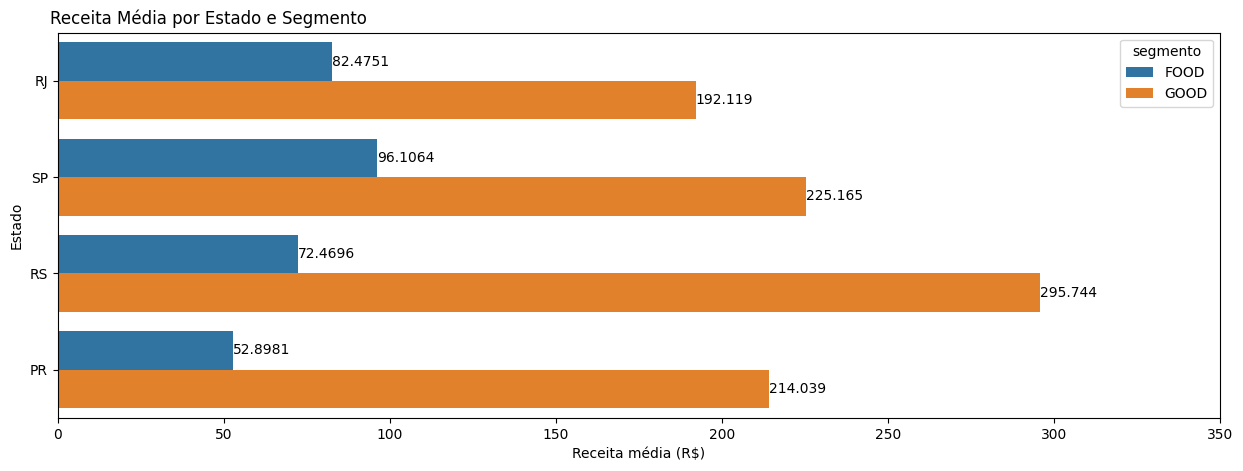

In [30]:
plt.figure(figsize=(15,5))
ax = sns.barplot(data = drv_dlv_str_hub, x = 'order_amount', y = 'hub_state', estimator='mean', hue = 'store_segment', errorbar = None)
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.ylabel('Estado')
plt.xlabel('Receita média (R$)')
plt.xlim(0, 350)
plt.title('Receita Média por Estado e Segmento', x = 0.13)
plt.legend(title='segmento')
plt.show()

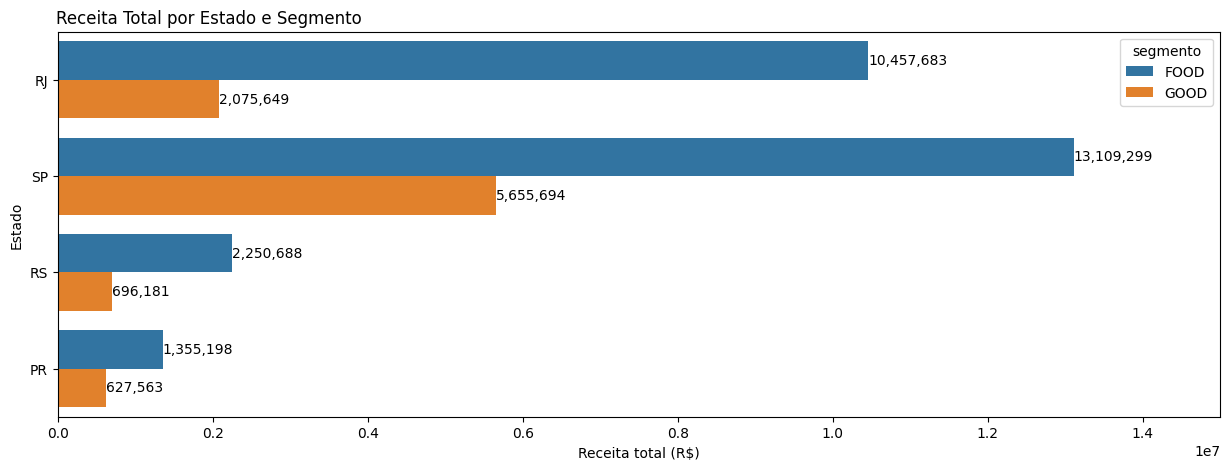

In [31]:
plt.figure(figsize=(15,5))
ax = sns.barplot(data = drv_dlv_str_hub, x = 'order_amount', y = 'hub_state', estimator='sum', hue = 'store_segment', errorbar = None)
ax.bar_label(ax.containers[0], fmt = '{:,.0f}')
ax.bar_label(ax.containers[1], fmt = '{:,.0f}')
plt.ylabel('Estado')
plt.xlim(0, 15_000_000)
plt.xlabel('Receita total (R$)')
plt.title('Receita Total por Estado e Segmento', x = 0.13)
plt.legend(title = 'segmento')
plt.show()

# Distribuição dos lucros

Se a empresa tem um gasto fixo de 5 reais por entrega, recebe 15% do valor de cada entrega como receita e, do total do lucro, distribui 20% em forma de bônus para os 2 mil funcionários, quanto cada um irá receber no período contido no dataset?

In [32]:
pedidos_finalizados = orders[orders['order_status'] == 'FINISHED']
gastos_totais = pedidos_finalizados.shape[0] * 5 # Gasto total
margem_entrega = (pedidos_finalizados.order_delivery_fee.sum() - gastos_totais) * 0.15
plr = (margem_entrega * 0.2)/2000

print(f'A empresa teve um total de {pedidos_finalizados.shape[0]} pedidos finalizados, com um gasto total de R$ {gastos_totais}.\nDistribuindo 20% da margem das taxas por 2000 colaboradores, cada um receberá R$ {plr:.2f}')

A empresa teve um total de 352020 pedidos finalizados, com um gasto total de R$ 1760100.
Distribuindo 20% da margem das taxas por 2000 colaboradores, cada um receberá R$ 6.42
